In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scalecast.Forecaster import Forecaster
from statsmodels.tsa.seasonal import seasonal_decompose

ModuleNotFoundError: No module named 'scalecast'

In [138]:
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

start = '2008-01-01'
end = '2020-12-30'
assets = ["PFE", "JNJ", "GOOGL", 
           "AAPL", "COST", "WMT", "KR", "JPM", 
          "BAC", "HSBC"]

assets.sort()

df = yf.download(assets, start = start, end = end)
df = df.loc[:,('Adj Close', slice(None))]
df.columns = assets

[*********************100%***********************]  10 of 10 completed


In [139]:
trai = df.loc[df.index < '01-01-2017']
tes = df.loc[df.index >= '01-01-2017']

In [140]:
test = tes['GOOGL'].resample('W').mean()
train = trai['GOOGL'].resample('W').mean()

In [141]:
test = test.to_frame(name='a')
train = train.to_frame(name='a')

In [142]:
test

,a
Date,
2017-01-08,4067.5126%
2017-01-15,4143.5201%
2017-01-22,4136.2750%
2017-01-29,4254.4200%
2017-02-05,4097.6500%
...,...
2020-12-06,9020.3300%
2020-12-13,8948.6699%
2020-12-20,8737.2598%


In [143]:
test = test.ffill()
train = train.ffill()

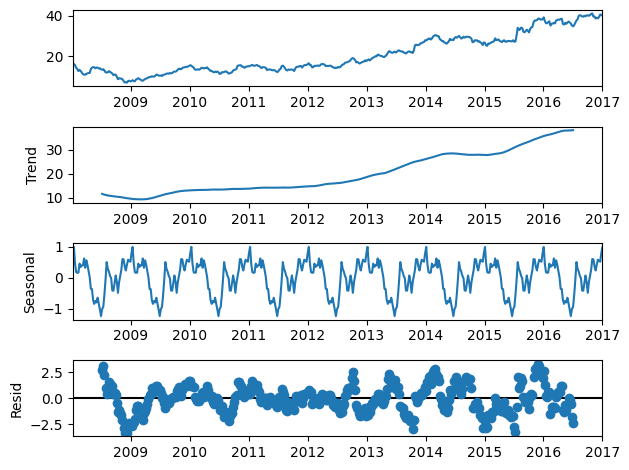

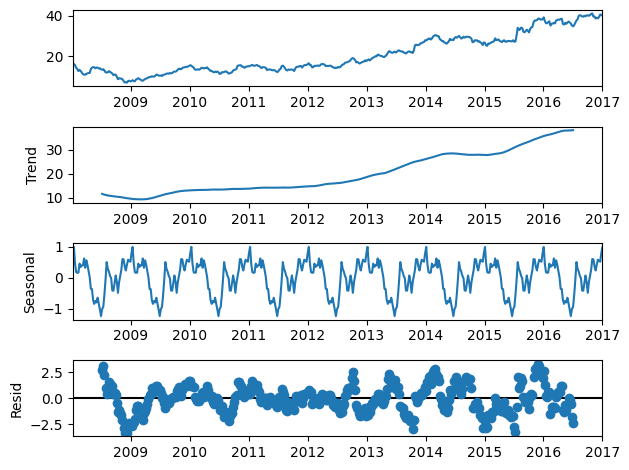

In [144]:
results = seasonal_decompose(train)
results.plot()

In [145]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [146]:
train

,a
Date,
2008-01-06,1691.2912%
2008-01-13,1611.1662%
2008-01-20,1555.7858%
2008-01-27,1422.5851%
2008-02-03,1368.8539%
...,...
2016-12-04,3879.9000%
2016-12-11,3950.4900%
2016-12-18,4066.6200%


In [147]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [148]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [149]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [150]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.29161627 0.26827783 0.2521469 ]
Predict this y: 
 [[0.21334884]]


In [151]:
X.shape

(1, 3, 1)

In [152]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [153]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [154]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [155]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [156]:
model.fit(generator,epochs=50)

Epoch 1/50
458/458 [==============================] - 6s 7ms/step - loss: 0.0078
Epoch 2/50
458/458 [==============================] - 3s 6ms/step - loss: 0.0021
Epoch 3/50
458/458 [==============================] - 3s 6ms/step - loss: 0.0019
Epoch 4/50
458/458 [==============================] - 2s 5ms/step - loss: 0.0013
Epoch 5/50
458/458 [==============================] - 3s 6ms/step - loss: 0.0012
Epoch 6/50
458/458 [==============================] - 3s 7ms/step - loss: 0.0010
Epoch 7/50
458/458 [==============================] - 3s 7ms/step - loss: 9.5130e-04
Epoch 8/50
458/458 [==============================] - 3s 7ms/step - loss: 9.6614e-04
Epoch 9/50
458/458 [==============================] - 3s 7ms/step - loss: 8.0788e-04
Epoch 10/50
458/458 [==============================] - 2s 5ms/step - loss: 7.1817e-04
Epoch 11/50
458/458 [==============================] - 3s 7ms/step - loss: 6.9097e-04
Epoch 12/50
458/458 [==============================] - 3s 7ms/step - loss: 6.6138e-04
E

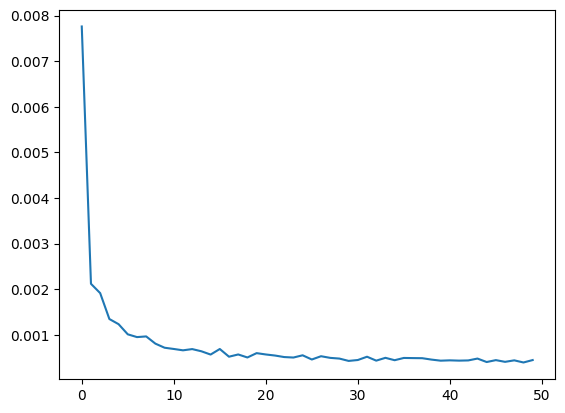

In [157]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [158]:
last_train_batch = scaled_train[-12:]

In [159]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [160]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 329ms/step


array([[0.9889913]], dtype=float32)

In [161]:
scaled_test[0]

array([0.98375051])

In [162]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 44ms/step


In [163]:
test_predictions

[array([0.9889913], dtype=float32),
 array([1.0211682], dtype=float32),
 array([1.0516089], dtype=float32),
 array([1.0802057], dtype=float32),
 array([1.1074314], dtype=float32),
 array([1.1334007], dtype=float32),
 array([1.1583112], dtype=float32),
 array([1.1823049], dtype=float32),
 array([1.2055858], dtype=float32),
 array([1.2282895], dtype=float32),
 array([1.250391], dtype=float32),
 array([1.2718812], dtype=float32),
 array([1.2928473], dtype=float32),
 array([1.3133326], dtype=float32),
 array([1.3333223], dtype=float32),
 array([1.3527875], dtype=float32),
 array([1.371707], dtype=float32),
 array([1.3900735], dtype=float32),
 array([1.4078877], dtype=float32),
 array([1.4251528], dtype=float32),
 array([1.441931], dtype=float32),
 array([1.458252], dtype=float32),
 array([1.4741186], dtype=float32),
 array([1.4895303], dtype=float32),
 array([1.5044215], dtype=float32),
 array([1.5187727], dtype=float32),
 array([1.5326016], dtype=float32),
 array([1.5459254], dtype=float3

In [164]:
true_predictions = scaler.inverse_transform(test_predictions)

In [165]:
test['Predictions'] = true_predictions

In [166]:
true_predictions

array([[40.8550524 ],
       [41.95974367],
       [43.00482726],
       [43.98660543],
       [44.92131382],
       [45.81288547],
       [46.66811013],
       [47.49185397],
       [48.29113183],
       [49.0705889 ],
       [49.8293739 ],
       [50.56717168],
       [51.286974  ],
       [51.99027058],
       [52.67655394],
       [53.34482955],
       [53.99436892],
       [54.62492649],
       [55.23651863],
       [55.82925994],
       [56.40528678],
       [56.96561414],
       [57.51034434],
       [58.03945692],
       [58.55069681],
       [59.04340099],
       [59.5181711 ],
       [59.97560057],
       [60.41622964],
       [60.84056578],
       [61.24911241],
       [61.64236064],
       [62.02076885],
       [62.38477496],
       [62.73481278],
       [63.0712343 ],
       [63.39442421],
       [63.70482044],
       [64.00285681],
       [64.28897123],
       [64.56355251],
       [64.82702629],
       [65.07976909],
       [65.32221473],
       [65.5547602 ],
       [65

<AxesSubplot: xlabel='Date'>

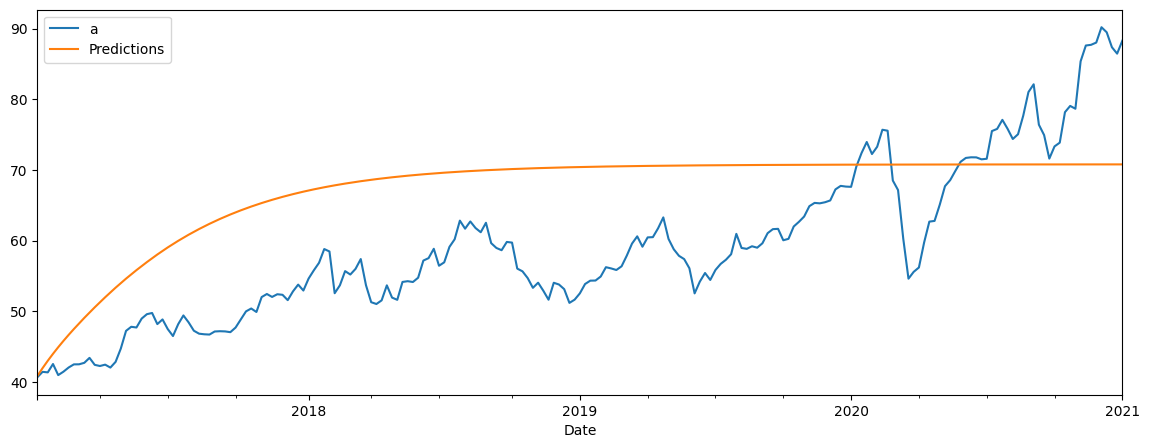

In [167]:
test.plot(figsize=(14,5))